In [ ]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# 加载下载好的库
import sys
sys.path.append('/home/aistudio/external-libraries')
import pywt
import math
import wfdb  # 读取信号工具箱
import pickle
import joblib
import numpy as np
from pywt import wavedec
import scipy.signal as sg
from pathlib import Path  # path方法
from concurrent.futures import ProcessPoolExecutor

PATH = Path("/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0")
sampling_rate = 360

# non-beat labels
invalid_labels = ['|', '~', '!', '+', '[', ']', '"', 'x']
# for correct R-peak location
tol = 0.05
#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    w = pywt.Wavelet('db5')
    coeffs = pywt.wavedec(data=new_df, wavelet='db5', level=8)
    cA8, cD8,  cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    # 将高频信号cD1、cD2置零
    cD1.fill(0)
    # 将其他中低频信号按软阈值公式滤波
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    recoeffs = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return recoeffs

def normalize(data):
    data = np.nan_to_num(data)  # removing NaNs and Infs
    data = data - np.mean(data)
    data = data / np.std(data)
    return data

def worker(record):
    # read ML II signal & r-peaks position and labels
    signal = wfdb.rdrecord((PATH / record).as_posix(), channels=[0]).p_signal[:, 0]

    annotation = wfdb.rdann((PATH / record).as_posix(), extension="atr")
    r_peaks, labels = annotation.sample, np.array(annotation.symbol)
    baseline = sg.medfilt(sg.medfilt(signal, int(0.2 * sampling_rate) - 1), int(0.6 * sampling_rate) - 1)
    filtered_signal = signal - baseline
    filtered_signal = wavelet_noising(filtered_signal)
    # remove non-beat labels
    indices = [i for i, label in enumerate(labels) if label not in invalid_labels]
    # 去除无效心拍后的值
    r_peaks, labels = r_peaks[indices], labels[indices]

    # align r-peaks
    newR = []
    # 对其R峰的位置，R峰对齐的范围[R_tol,R_tol]
    for r_peak in r_peaks:
        r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
        r_right = np.minimum(r_peak + int(tol * sampling_rate), len(filtered_signal))
        newR.append(r_left + np.argmax(filtered_signal[r_left:r_right]))
    r_peaks = np.array(newR, dtype="int")
    '''归一化心电信号'''
    # remove inter-patient variation
    normalized_signal= normalize(filtered_signal)
    # AAMI categories
    AAMI = {
        "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
        "A": 1, "a": 1, "S": 1, "J": 1,  # SVEB
        "V": 2, "E": 2,  # VEB
        "F": 3,  # F
        "/": 4, "f": 4, "Q": 4  # Q
    }
    categories = [AAMI[label] for label in labels]

    return {
        "record": record,
        "signal": normalized_signal, "r_peaks": r_peaks, "categories": categories
    }


if __name__ == "__main__":
    # for multi-processing
    cpus = 16 if joblib.cpu_count() > 16 else joblib.cpu_count() - 1

    data = [
        '100', '104', '108', '113', '117', '122', '201', '207', '212', '217', '222', '231',
        '101', '105', '109', '114', '118', '123', '202', '208', '213', '219', '223', '232',
        '102', '106', '111', '115', '119', '124', '203', '209', '214', '220', '228', '233',
        '103', '107', '112', '116', '121', '200', '205', '210', '215', '221', '230', '234'
    ]
    print("train processing...")
    with ProcessPoolExecutor(max_workers=cpus) as executor:
        data = [result for result in executor.map(worker, data)]
    with open((PATH / "mitdb.pkl").as_posix(), "wb") as f:
        #序列化对象，将结果数据流写入到文件对象中，p=4(序列化模式)表示以二进制的形式序列化
        pickle.dump((data ), f, protocol= 4)
    print("ok!")

train processing...
ok!


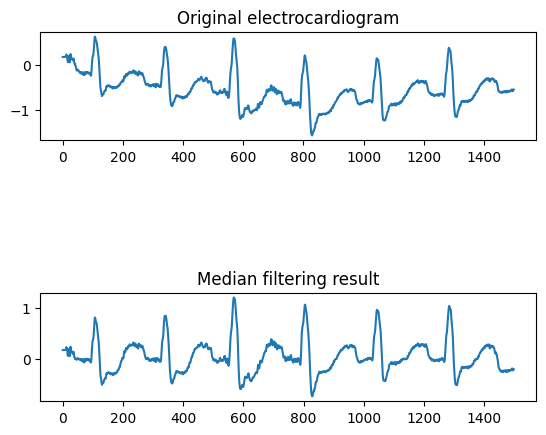

In [ ]:
import os
import pywt
import wfdb
import numpy as np
import scipy.io as io
from scipy import signal
import scipy.signal as sg
import matplotlib.pyplot as plt
from scipy.signal import medfilt
Initial_intercept_point = 0
Final_intercept_point = 2000
ecg = wfdb.rdrecord('/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/109', sampfrom=0, sampto=1500, physical=True, channels=[0, ])
ecg = ecg.p_signal.flatten()
index = []
data = []
for i in range(len(ecg)-1):
    X = float(i)
    Y = float(ecg[i])
    index.append(X)
    data.append(Y)
length=len(data)
sampling_rate=360

# filtering uses a 200-ms width median filter and 600-ms width median filter
baseline = sg.medfilt(sg.medfilt(data, int(0.2 * sampling_rate) -1), int(0.6 * sampling_rate)- 1)
filtered_signal = data - baseline
plt.subplot(3, 1,1)
plt.plot(ecg)
plt.title('Original electrocardiogram')
plt.subplot(3, 1, 3)
plt.plot(filtered_signal)  # 显示中值去噪结果
plt.title('Median filtering result')
plt.show()

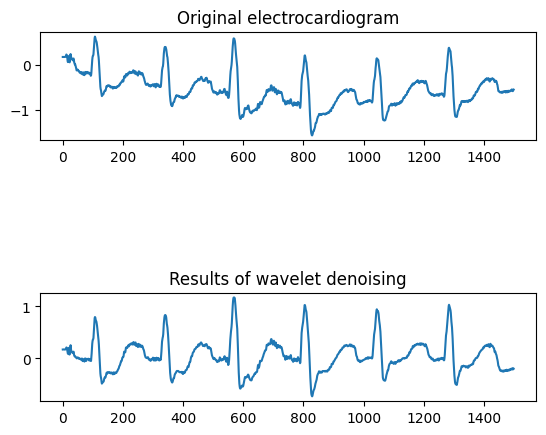

In [ ]:
#封装成函数
def sgn(num):
    if(num > 0.0):
        return 1.0
    elif(num == 0.0):
        return 0.0
    else:
        return -1.0

def wavelet_noising(new_df):
    data = new_df
    w = pywt.Wavelet('db5')
    # [ca3, cd3, cd2, cd1] = pywt.wavedec(data, w, level=3)  # 分解波
    coeffs = pywt.wavedec(data=new_df, wavelet='db5', level=7)
    cA7, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    # 将高频信号cD1、cD2置零
    cD1.fill(0)
    #cD2.fill(0)
    # 将其他中低频信号按软阈值公式滤波
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    recoeffs = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return recoeffs
    rdata = rdata

data_denoising = wavelet_noising(filtered_signal)  # 调用小波去噪函数
plt.subplot(3, 1,1)
plt.plot(ecg)
plt.title('Original electrocardiogram')
plt.subplot(3, 1,3)
plt.plot(data_denoising)  # 显示去噪结果
plt.title('Results of wavelet denoising')
plt.show()

In [ ]:

pip install --upgrade paddlepaddle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
print(sys.version)


3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [ ]:
!pip3 install paddlepaddle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
python -m pip install paddlepaddle-gpu==2.4.1.post112

SyntaxError: ignored

In [ ]:
import paddle
import numpy as np
import paddle.nn as nn
import paddle.fluid as fluid
from paddle.nn import initializer

class Shrinkage(nn.Layer):
    def __init__(self,  channel,  reduction=4):
        super(Shrinkage, self).__init__()
        self.gap = nn.AdaptiveAvgPool1D(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction),
            nn.BatchNorm1D(channel//reduction),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(channel//reduction, channel),
            nn.Sigmoid(),
        )
    def forward(self, x):
        b, c, _= x.shape
        y1 = self.gap(x).reshape([b, c])
        y = self.fc(y1).reshape([b, c,1])
        return x * y.expand_as(x)
class SpatialAttention(nn.Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv1D(2, 24, kernel_size, padding=padding, bias_attr=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = paddle.mean(x, dim=1, keepdim=True)
        max_out, _ = paddle.max(x, dim=1, keepdim=True)
        x = paddle.concat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
class SKConv(nn.Layer):
    def __init__(self, in_channels, out_channels, stride=1, M=2, r=2, L=32):
        super(SKConv, self).__init__()
        d = max(in_channels // r, L)  # 计算向量Z 的长度d
        self.M = M
        self.out_channels = out_channels
        self.conv = nn.ModuleList()  # 根据分支数量 添加 不同核的卷积操作
        for i in range(M):
            # 为提高效率，原论文中 扩张卷积5x5为 （3X3，dilation=2）来代替。 且论文中建议组卷积G=32
            self.conv.append(nn.Sequential(
                nn.Conv1D(in_channels, out_channels, 3, stride, padding=1 + i, dilation=1 + i, groups=32,bias_attr=False),
                nn.BatchNorm1D(out_channels),
                nn.ReLU(inplace=True)))
        self.global_pool = nn.AdaptiveAvgPool1D(1)  # 自适应pool到指定维度    这里指定为1，实现 GAP
        self.fc1 = nn.Sequential(nn.Conv1D(out_channels, d, 1, bias_attr=False),
                                 nn.BatchNorm1D(d),
                                 nn.ReLU())  # 降维
        self.fc2 = nn.Conv1D(d, out_channels * M, 1, 1, bias_attr==False)  # 升维
        self.softmax = nn.Softmax(dim=1)  # 指定dim=1  使得两个全连接层对应位置进行softmax,保证 对应位置a+b+..=1

    def forward(self, input):
        batch_size = input.size(0)
        output = []
        # the part of split
        for i, conv in enumerate(self.conv):
            output.append(conv(input))
        # the part of fusion
        U = reduce(lambda x, y: x + y, output)  # 逐元素相加生成 混合特征U
        s = self.global_pool(U)
        z = self.fc1(s)  # S->Z降维
        a_b = self.fc2(z)  # Z->a，b 升维  论文使用conv 1x1表示全连接。结果中前一半通道值为a,后一半为b
        a_b = a_b.reshape(batch_size, self.M, -1)  # 调整形状，变为 两个全连接层的值
        a_b = self.softmax(a_b)  # 使得两个全连接层对应位置进行softmax
        a_b = list(a_b.chunk(self.M, dim=1))  # split to a and b   chunk为pytorch方法，将tensor按照指定维度切分成 几个tensor块
        a_b = list(map(lambda x: x.reshape(batch_size, self.out_channels, 1), a_b))  # 将所有分块  调整形状，即扩展两维
        V = list(map(lambda x, y: x * y, output, a_b))  # 权重与对应  不同卷积核输出的U 逐元素相乘
        V = reduce(lambda x, y: x + y, V)  # 两个加权后的特征 逐元素相加
        return V

NameError: ignored

In [ ]:
class ResBlk(nn.Layer):
    expansion=1
    def __init__(self,in_channel,out_channel,stride=1,downsample=None):
        '''downsample对应虚线残差结构'''
        super(ResBlk,self).__init__()
        self.downsample=downsample
        self.conv1=nn.Conv1D( in_channel, out_channel,kernel_size=3,stride=stride,padding=1 )
        self.bn1=nn.BatchNorm1D(out_channel)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv1D(in_channels=out_channel,out_channels=out_channel,
                             kernel_size=3,stride=1,padding=1,bias_attr=False)
        self.bn2=nn.BatchNorm1D(out_channel)
        self.se=Shrinkage(out_channel)
        self.sa=SpatialAttention()
        if self.downsample:
           self.downsample = nn.Sequential(

                       nn.Conv1D(in_channels=in_channel, out_channels=out_channel , kernel_size=1, stride=stride, bias_attr=False),
                       nn.BatchNorm1D(out_channel),
            )
    def forward(self,x):
        identity=x
        if self.downsample is not None:#虚线部分的残差结构,需要下采样 stride=2的pooling
            identity=self.downsample(x)#捷径分支，short cut
        #残差块中的第一个卷积层
        out=self.conv1(x)
        out=self.relu(self.bn1(out))
        #残差块中的第二个卷积层
        out=self.conv2(out)
        out=self.bn2(out)
        out+=identity
        out=self.relu(out)
        out=self.se(out)+identity
        return out
'''resnet50/101/152的残差结构，用的是1*1+3*3+1*1的卷积'''
class Bottleneck(nn.Layer):
    expansion=4
    def __init___(self,in_channel,out_channel,stride=1,downsample=None):
        super(Bottleneck,self).__init__()
        '''第一层卷积层，使用1*1的卷积核，stride=1,未使用padding'''
        self.conv1=nn.Conv1D(in_channels=in_channel,out_channels=out_channel,
                             kernel_size=1,stride=1,bias_attr=False)
        self.bn1=nn.BatchNorm1D(out_channel)
        '''第二层卷积层，使用3*3的卷积核，stride=2,padding=1'''
        self.drop1=nn.Dropout(0)
        self.conv2=nn.Conv1D(in_channels=out_channel,out_channels=out_channel,
                             kernel_size=3,stride=stride,padding=1,bias_attr=False)
        self.bn2=nn.BatchNorm1D(out_channel)
        '''第三层卷积层，使用1*1的卷积核，stride=1'''
        self.drop2=nn.Dropout(0)
        self.conv3=nn.Conv1D(in_channels=out_channel,out_channels=out_channel*self.expansion,
                             kernel_size=1,stride=1,bias_attr=False)
        self.bn3=nn.BatchNorm1D(out_channel*self.expansion)
        self.relu=nn.LeakyReLU()
        self.drop4=nn.Dropout(0)
        self.downsample=downsample
    def forward(self,x):
        identity=x
        if self.downsample is not None:
            identity=self.downsample(x)#捷径分支 short cut
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.drop1(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)
        out=self.drop2(out)
        out=self.conv3(out)
        out=self.bn3(out)
        out+=identity
        out=self.relu(out)
        return out

In [ ]:
class ResNet(nn.Layer):
    def __init__(self,block,block_num,num_classes=4,include_top=True,num_group=32):
        super(ResNet,self).__init__()
        self.include_top=include_top
        self.in_channel=24
        #-----------输入网络之前--------------------------
        self.conv1=nn.Conv1D(1,out_channels=self.in_channel,kernel_size=7,stride=2,padding=3,bias_attr=False)
        self.bn1=nn.BatchNorm1D(self.in_channel)
        self.relu=nn.ReLU()
        "------------------多尺度卷积模块---------------------"
        self.cnn1 = nn.Sequential(nn.Conv1D(self.in_channel,8, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm1D(8),
                                  nn.ReLU()
                                  )
        self.cnn2 = nn.Sequential(nn.Conv1D(self.in_channel, out_channels=8, kernel_size=5, stride=1, padding=2),
                                  nn.BatchNorm1D(8),
                                  nn.ReLU()
                                  )
        self.cnn3 = nn.Sequential(nn.Conv1D(self.in_channel, out_channels=8, kernel_size=7, stride=1, padding=3),
                                  nn.BatchNorm1D(8),
                                  nn.ReLU()
        )
        "-------------LSTM(双向长短时记忆网络)循环卷积网络--------------"
        self.rnn_layer = nn.LSTM(  # 1：bilstm,hidden_size=64，效果仍旧是s，f类的precision不高
            # lstm:hidden_size=32
            input_size=9,
            hidden_size=32,
            num_layers=1,
            direction='bidirectional',
            time_major=False,
            dropout=0,
        )
        self.se1=Shrinkage(8)
        self.sa1=SpatialAttention()
        self.maxpool=nn.MaxPool1D(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64, block_num[0])#第一个模块结构
        self.layer2=self._make_layer(block,64,block_num[1] ,stride=2)#第二个模块结构
        self.layer3=self._make_layer(block,64,block_num[2], stride=2)#第三个模块结构
        self.layer4=self._make_layer(block,64,block_num[3],stride=2)#第四个模块结构
        self.softmax = nn.Softmax(-1)
        self.dropout = nn.Dropout(0.3)
        if self.include_top:
            self.avgpool=nn.AvgPool1D(1,stride=1)
            self.fc=nn.Linear(64*64*block.expansion,num_classes)
        for m in self.sublayers():
            if isinstance(m, paddle.nn.Conv1D):
                paddle.nn.initializer.KaimingNormal()
    def _make_layer(self,block,channel,block_num, stride=1):
        downsample=None
        if stride!=1 or self.in_channel !=channel*block.expansion:
            downsample=nn.Sequential(
                nn.Conv1D(self.in_channel,channel*block.expansion,
                          kernel_size=1,stride=stride,bias_attr=False),
                nn.BatchNorm1D(channel*block.expansion))#此处用于处理输入特征图
        layers=[]
        layers.append(block(self.in_channel,channel,downsample=downsample,stride=stride ))
        self.in_channel=channel*block.expansion
        for _ in range(1,block_num):
            layers.append(block(self.in_channel,channel ))
        return nn .Sequential(*layers)
    def forward(self,x):
        x1=self.relu(self.bn1(self.conv1(x)))
        x=self.maxpool(x1)
        output1 = self.cnn1(x)
        output1=self.se1(output1)
        output2 = self.cnn2(x)
        output2=self.se1(output2)
        output3 = self.cnn3(x)
        output3=self.se1(output3)
        output3=self.dropout(output3)
        x = paddle.concat([output1, output2, output3], axis=1)
        x=self.layer1(x)
        x = self.dropout(x)
        x=self.layer2(x)
        x = self.dropout(x)
        x=self.layer3(x)
        x = self.dropout(x)
        x=self.layer4(x)
        x = self.dropout(x)
        if self.include_top:
            x=self.avgpool(x)
            x,_=self.rnn_layer(x)
            x=paddle.flatten(x,1)
            x = self.dropout(x)
            x=self.fc(x)
        return x

    def resnet18(num_classes=4,include_top=True):
        return ResNet(ResBlk,[2,2,2,2],num_classes=num_classes,include_top=include_top)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model= ResNet.resnet18()
paddle.summary(model,(-1,1,280))

In [ ]:
import os
import sys
import time
import joblib
import random
import paddle
import numpy as np
import PIL.Image as Image
from functools import partial
import matplotlib.pyplot as plt
import paddle.optimizer as optim
from imblearn.over_sampling import SMOTE
from paddle.optimizer.lr import StepDecay
from paddle.io import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

# 设置随机数
seed = 0
paddle.seed(seed)
np.random.seed(seed)
random.seed(seed)
'''连续小波变换需要的参数'''
def worker(data):
    # heartbeat segmentation interval
    before, after =120 , 160
    #print(coeffs.shape)# (100,650000)
    r_peaks, categories = data["r_peaks"], data["categories"]
    record=data[ "signal"]#(650000,)

    x1,y= [], []
    for i in range(len(r_peaks)):
        if i == 0 or i == len(r_peaks) - 1:
            continue
        if categories[i] == 4:  # remove AAMI Q class
            continue
        x1.append(record[ r_peaks[i] - before: r_peaks[i] + after ]) #(1861,200)
        y.append(categories[i])#(1861,),(1761,),(2025,),(2530,)
    return x1, y
tic = time.time()

#中值滤波
def load_data(filename="/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/mitdb.pkl"):
    import pickle
    from sklearn.preprocessing import RobustScaler
    with open(filename, "rb") as f:
        train_data = pickle.load(f)

    cpus = 16 if joblib.cpu_count() > 16 else joblib.cpu_count() - 1  # for multi-process

    # for training
    x1_train,  y_train = [], []
    for x1,  y in map(partial(worker), train_data):

        x1_train.append(x1)#(1,1861,100,100)

        y_train.append(y)#(1,1861)

    x1_train = np.expand_dims(np.concatenate(x1_train, axis=0), axis=1).astype(np.float32)
    y_train = np.concatenate(y_train, axis=0).astype(np.int64)

    return x1_train,y_train
X,Y=load_data(filename="/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/mitdb.pkl")
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

'''Over_sampling'''
x_train = np.reshape(x_train, [x_train.shape[0] * x_train.shape[1], -1])
# print('x_train',x_train.shape)#(80504,200)
classes = np.unique(y_train)
print('class',classes)
nums = []
for cl in classes:
    ind = np.where(classes == cl)[0][0]
    nums.append(len(np.where(y_train.flatten() == ind)[0]))  # [71987, 2228, 5641, 648]
print(nums)
n_oversampling =30000
ratio = {0: nums[0], 1:n_oversampling, 2:20000, 3:n_oversampling}

# 数据扩增
sm = SMOTE(random_state=12, sampling_strategy=ratio)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('smote:',x_train.shape)#(101987,200)
x_train = np.reshape(x_train, [-1, x_test.shape[1], x_test.shape[2]])  # (101987,1,200)
# print(X_train.shape)
print('Classes in the training set: ', classes)
for cl in classes:
    ind = np.where(classes == cl)[0][0]
    print(cl, len(np.where(y_train.flatten() == ind)[0]))
X_train = paddle.to_tensor(x_train)
print('x_train.shape',X_train.shape)

# 设置训练集和测试集
X_test = paddle.to_tensor(x_test)
Y_train = paddle.to_tensor(y_train)
Y_test = paddle.to_tensor(y_test)
train_db = TensorDataset([X_train, Y_train])
test_db = TensorDataset([X_test, Y_test])
toc = time.time()
print('Time for data processing--- '+str(toc-tic)+' seconds---')

test_flag = False #测试标志，True时加载保存好的模型进行测试

save_dir = "/home/aistudio/work/weight" # 存储权重的路径
#在监控指标没有提升的情况下，epochs 等待轮数。等待大于该值监控指标始终没有提升，则提前停止训练。
patience = 5
batchsize =256
lr =0.00001
epochs =100
#批次大小
batch_size = 64
#动量法系数
momentum = 0
#权重衰减
weight_decay = 5e-4

'''利用 Dataloader加载数据集'''
train_load = DataLoader(train_db, batch_size=batchsize, shuffle=True )
source_batch, target_batch = iter(train_load).next()
print('source_batch:', source_batch.shape, 'target_batch:', target_batch.shape)
test_load = DataLoader(test_db, batch_size=batchsize, shuffle=True )
dataloaders = {
    "train": train_load,
    "validation": test_load
}

In [ ]:
!pip install visualdl


In [ ]:
model1=paddle.Model(model)
# 设定可视化工具VisualDL的日志数据保存路径
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 只保存验证集准确率最高的模型，即最优模型
class SaveBestModel(paddle.callbacks.Callback):
    def __init__(self, target=0.5, path='./home/aistudio/work/best-model/best_model', verbose=0):
        self.target = target
        self.epoch = None
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch

    def on_eval_end(self, logs=None):
        if logs.get('acc') > self.target:
            self.target = logs.get('acc')
            self.model.save(self.path)
            print('best acc is {} at epoch {}'.format(self.target, self.epoch))
callback_savebestmodel = SaveBestModel(target=0.5, path='./home/aistudio/work/best-model/best_model')
# 训练数据给我们提供了后续分析训练过程的历史记录，因此保存训练过程中的数据非常重要
import csv
class SaveTrainingData(paddle.callbacks.Callback):
    def __init__(self, data_filepath=''):
        self.data_filepath = data_filepath

    def on_train_begin(self, logs=None):
        file = open(self.data_filepath, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(['time', 'training_accuracy'])
        writer.writerow([0.0, 0.0])
        file.close()

        self.train_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        total_time = time.time() - self.train_start_time
        file = open(self.data_filepath, 'a')
        writer = csv.writer(file)
        writer.writerow([round(total_time,1), round(logs['acc'], 4)])
        file.close()

if not os.path.exists('training_data'):
    os.mkdir('training_data')
callback_savetrainingdata = SaveTrainingData(data_filepath="training_data/result.csv")

# 设置优化器
optim = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters())
 #早期停止

# 准备模型
model1.prepare(optim,loss =paddle.nn.CrossEntropyLoss(),metrics=paddle.metric.Accuracy())
# 开始训练
model1.fit(train_load,test_load,epochs=epochs,batch_size=batch_size,save_dir=save_dir, verbose=1, callbacks=[visualdl,callback_savebestmodel,callback_savetrainingdata])